In [ ]:
!rm -R sample_data
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

/
Mounted at /content/gdrive
'Biwak miejsca.gmap'   data_for_train	       'Google Earth'   Passwords.kdbx
'Colab Notebooks'     'Forgotten places.gmap'  'My Drive'


In [ ]:
!cp /mydrive/data_for_train/social_robot/fer2013.csv.zip /content/
%cd content/
!unzip /content/fer2013.csv.zip -d /content/data
!rm -R /content/fer2013.csv.zip

/content
Archive:  /content/fer2013.csv.zip
  inflating: /content/data/fer2013.csv  


In [1]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
df = pd.read_csv('/content/data/fer2013.csv')
print(f"avable values: {df.emotion.unique()}\n")
print(f"samples amound for category:\n{df.emotion.value_counts()}")

avable values: [0 2 4 6 3 5 1]

samples amound for category:
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


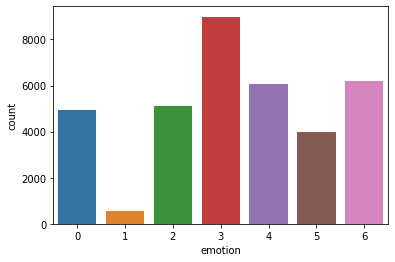

In [ ]:
sns.countplot(df.emotion)
plt.show()

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df = df[df.emotion.isin([0, 2, 3, 4, 5])]

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(29142, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(29142, 5)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3, 5: 4}


In [ ]:
emotion_label_to_text = {0:'anger', 1:'fear', 2:'happiness', 3: 'sadness', 4: 'surprise'}

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((26227, 48, 48, 1), (2915, 48, 48, 1), (26227, 5), (2915, 5))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu', input_shape=(img_width, img_height, img_depth)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(762, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(762, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

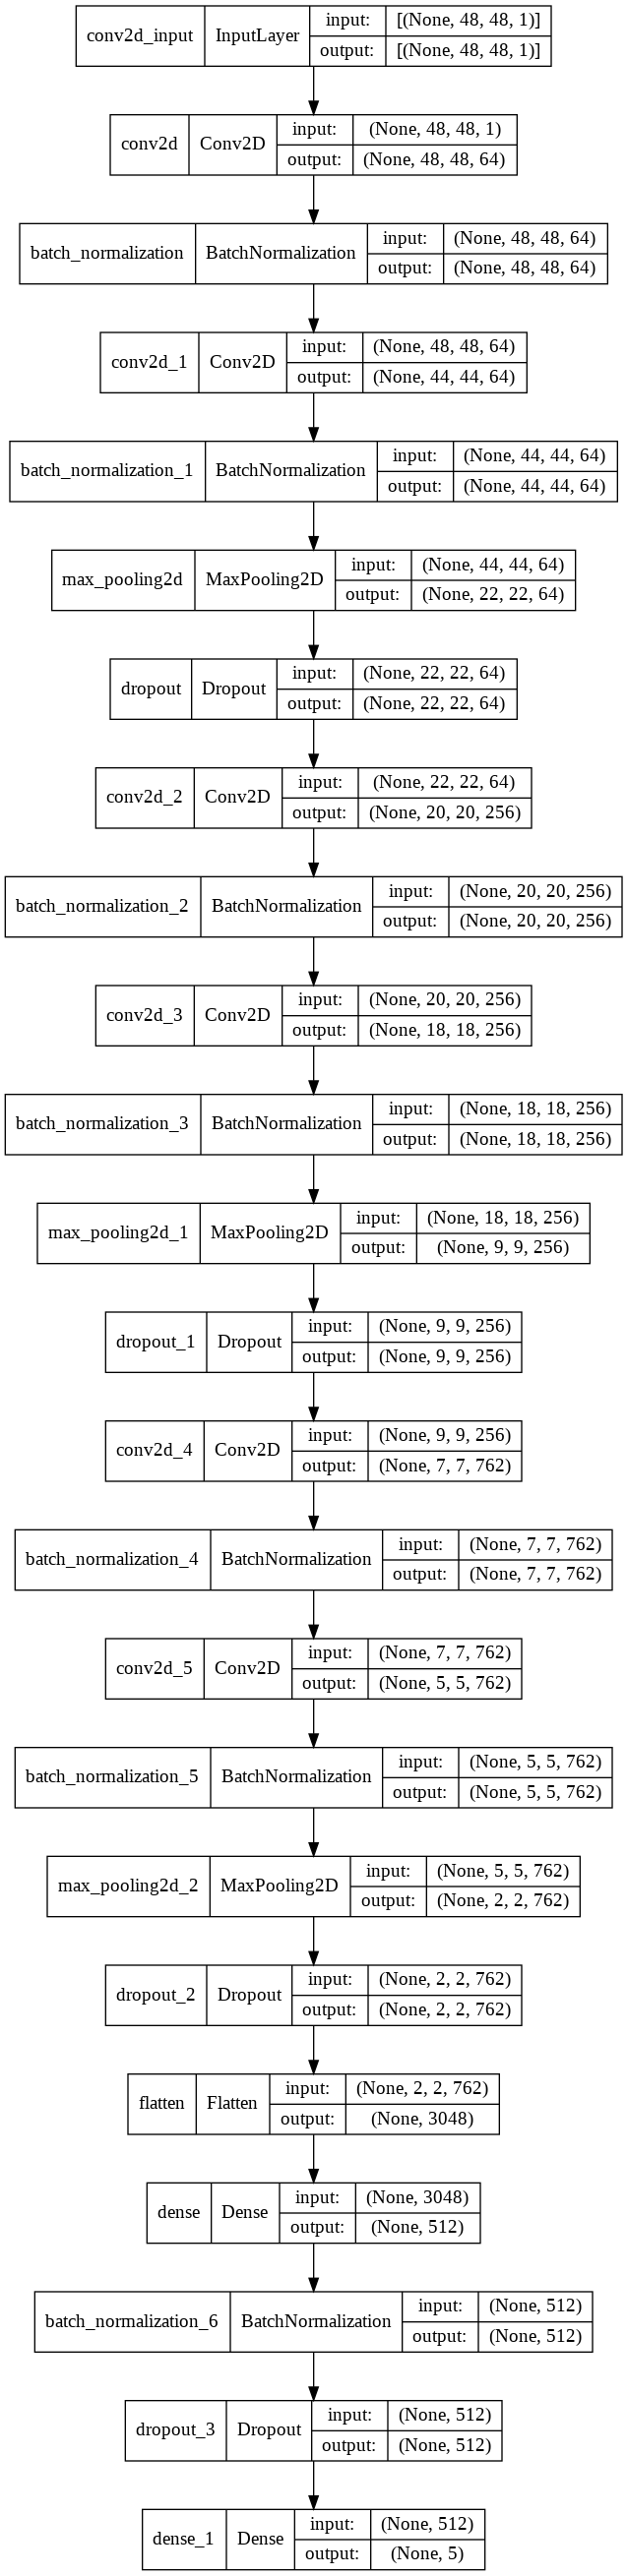

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32
epochs = 150
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/150
819/819 [==============================] - 100s 82ms/step - loss: 1.8975 - acc: 0.2901 - val_loss: 1.5794 - val_acc: 0.3612 - lr: 0.0010
Epoch 2/150
819/819 [==============================] - 65s 80ms/step - loss: 1.4630 - acc: 0.3931 - val_loss: 2.5134 - val_acc: 0.2089 - lr: 0.0010
Epoch 3/150
819/819 [==============================] - 65s 80ms/step - loss: 1.3435 - acc: 0.4392 - val_loss: 1.2091 - val_acc: 0.5087 - lr: 0.0010
Epoch 4/150
819/819 [==============================] - 65s 79ms/step - loss: 1.2469 - acc: 0.4849 - val_loss: 1.1225 - val_acc: 0.5475 - lr: 0.0010
Epoch 5/150
819/819 [==============================] - 65s 79ms/step - loss: 1.1895 - acc: 0.5142 - val_loss: 1.1287 - val_acc: 0.5407 - lr: 0.0010
Epoch 6/150
819/819 [==============================] - 65s 79ms/step - loss: 1.1399 - acc: 0.5372 - val_loss: 0.9929 - val_acc: 0.5918 - lr: 0.0010
Epoch 7/150
819/819 [==============================] - 65s 79ms/step - loss: 1.1095 - acc: 0.5518 - val_loss: 0

In [ ]:
model.save('/mydrive/data_for_train/social_robot/emotion_model_1.h5')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

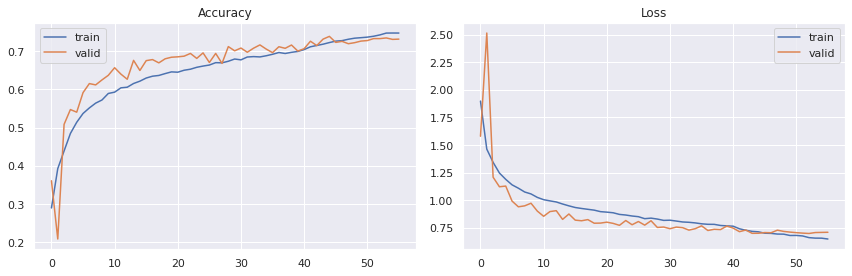

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['acc'], label='train')
sns.lineplot(history.epoch, history.history['val_acc'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')

NameError: ignored

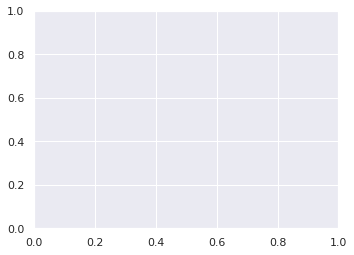

In [2]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['acc'], label='train')
sns.lineplot(history.epoch, history.history['val_acc'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')